流式输出内容被截断，只能显示最后 5000 行内容。
❌ 无效中间点: x=0.89, y=0.24, θ=323.6
🚫 Invalid at x=1.145, y=0.187, θ=263.8
❌ 无效中间点: x=1.15, y=0.19, θ=263.8
🚫 Invalid at x=0.973, y=0.187, θ=19.2
❌ 无效中间点: x=0.97, y=0.19, θ=19.2
🚫 Invalid at x=1.328, y=0.701, θ=266.4
❌ 无效中间点: x=1.33, y=0.70, θ=266.4
🚫 Invalid at x=1.129, y=0.216, θ=263.4
❌ 无效中间点: x=1.13, y=0.22, θ=263.4
🚫 Invalid at x=1.036, y=0.278, θ=148.4
❌ 无效中间点: x=1.04, y=0.28, θ=148.4
🚫 Invalid at x=1.029, y=0.296, θ=325.0
❌ 无效中间点: x=1.03, y=0.30, θ=325.0
🚫 Invalid at x=1.423, y=0.388, θ=62.9
❌ 无效中间点: x=1.42, y=0.39, θ=62.9
🚫 Invalid at x=0.960, y=0.308, θ=325.3
❌ 无效中间点: x=0.96, y=0.31, θ=325.3
🚫 Invalid at x=1.317, y=0.368, θ=167.9
❌ 无效中间点: x=1.32, y=0.37, θ=167.9
🚫 Invalid at x=0.954, y=0.243, θ=271.6
❌ 无效中间点: x=0.95, y=0.24, θ=271.6
🚫 Invalid at x=0.946, y=0.260, θ=150.9
❌ 无效中间点: x=0.95, y=0.26, θ=150.9
🚫 Invalid at x=1.071, y=0.303, θ=350.4
❌ 无效中间点: x=1.07, y=0.30, θ=350.4
🚫 Invalid at x=1.599, y=0.140, θ=6.6
❌ 无效中间点: x=1.60, y=0.14, θ=6.6
🚫 Invalid at

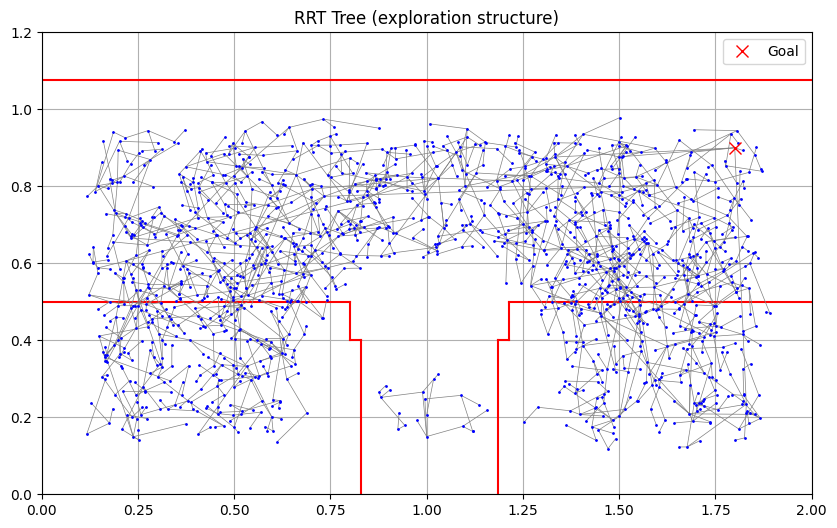

In [331]:
start = EEState(1.0, 0.15, 270)
goal = EEState(1.8, 0.9, 60)
path, tree = rrt_connect(start, goal, EE_full, is_within_custom_bounds, max_iter=10000)

if path:
    plot_rrt_path(path, EE_full, draw_borders)
else:
    print("❌ Failed to find a path.")
    plot_rrt_tree(tree, EE_full, draw_borders, goal_state=goal)


In [332]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# == 创建 EE 原始图形 ==
theta1 = np.linspace(np.pi, 110 * np.pi / 180, int((np.pi - 110 * np.pi / 180) / 0.01) + 1)
theta2 = np.linspace(60 * np.pi / 180, np.pi, int((np.pi - 60 * np.pi / 180) / 0.01) + 1)
L4 = 0.385

EEside = np.concatenate([
    31.75 * np.exp(1j * theta1),
    [-10.86 + 29.83j,
     105.29 + 72.17j,
     119.68 + 80.76j,
     129.5 + 80.76j,
     129.5 + 96j,
     55 + 96j,
     -148 + 50j,
     -160 + 44.7j],
    -L4 * 1000 + 49 * np.exp(1j * theta2)
]) / 1000

EE_full = L4 + np.concatenate([EEside[::-1], np.real(EEside) - 1j * np.imag(EEside)])
wafer_radius = 0.15
wafer_base = wafer_radius * np.exp(1j * np.linspace(0, 2*np.pi, 200)) + 0.385

# == 边界绘图 ==
def draw_borders(ax):
    x1 = np.linspace(0, 2, 100);     y1 = np.ones_like(x1) * 1.075
    x2 = np.linspace(0, 0.8, 100);   y2 = np.ones_like(x2) * 0.5
    x9 = np.linspace(1.215, 2, 100); y9 = np.ones_like(x9) * 0.5
    y3 = np.linspace(0.5, 0.4, 100); x3 = np.ones_like(y3) * 0.8
    y8 = np.linspace(0.4, 0.5, 100); x8 = np.ones_like(y8) * 1.215
    x4 = np.linspace(0.8, 0.83, 100); y4 = np.ones_like(x4) * 0.4
    x7 = np.linspace(1.185, 1.215, 100); y7 = np.ones_like(x7) * 0.4
    y5 = np.linspace(0.4, 0, 100); x5 = np.ones_like(y5) * 0.83
    y6 = np.linspace(0, 0.4, 100); x6 = np.ones_like(y6) * 1.185
    segments = [(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5),
                (x6, y6), (x7, y7), (x8, y8), (x9, y9)]
    for x, y in segments:
        ax.plot(x, y, 'r', linewidth=1.5)

# == 控制图更新 ==
def update_plot(x_shift=0.1, y_shift=0.1, theta_deg=0):
    theta = np.deg2rad(theta_deg)
    center = x_shift + 1j * y_shift
    EE_trans = (EE_full - 0.385) * np.exp(1j * theta) + center
    wafer_trans = (wafer_base - 0.385) * np.exp(1j * theta) + center

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1.2)
    ax.set_aspect('equal')
    draw_borders(ax)
    ax.fill(EE_trans.real, EE_trans.imag, color='gray', alpha=0.6, label='End Effector')
    ax.fill(wafer_trans.real, wafer_trans.imag, color='red', alpha=0.4, label='Wafer')
    ax.set_title(f"EE Center: ({x_shift:.3f}, {y_shift:.3f}) | θ = {theta_deg}°")
    ax.legend()
    plt.grid(True)
    plt.show()

# == 启动交互滑块 ==
interact(
    update_plot,
    x_shift=FloatSlider(value=0.1, min=0, max=2, step=0.01, description='X位置'),
    y_shift=FloatSlider(value=0.1, min=0, max=1.2, step=0.01, description='Y位置'),
    theta_deg=FloatSlider(value=0, min=0, max=360, step=1, description='旋转角')
);


interactive(children=(FloatSlider(value=0.1, description='X位置', max=2.0, step=0.01), FloatSlider(value=0.1, de…

流式输出内容被截断，只能显示最后 5000 行内容。
❌ 无效中间点: x=0.98, y=0.24, θ=335.1
🚫 Invalid at x=0.975, y=0.236, θ=280.6
❌ 无效中间点: x=0.98, y=0.24, θ=280.6
🚫 Invalid at x=1.109, y=0.230, θ=254.3
❌ 无效中间点: x=1.11, y=0.23, θ=254.3
🚫 Invalid at x=1.034, y=0.292, θ=11.5
❌ 无效中间点: x=1.03, y=0.29, θ=11.5
🚫 Invalid at x=0.979, y=0.241, θ=155.4
❌ 无效中间点: x=0.98, y=0.24, θ=155.4
🚫 Invalid at x=1.009, y=0.337, θ=192.7
❌ 无效中间点: x=1.01, y=0.34, θ=192.7
🚫 Invalid at x=1.035, y=0.233, θ=26.0
❌ 无效中间点: x=1.04, y=0.23, θ=26.0
🚫 Invalid at x=1.035, y=0.233, θ=26.0
❌ 无效中间点: x=1.04, y=0.23, θ=26.0
🚫 Invalid at x=1.022, y=0.233, θ=157.0
❌ 无效中间点: x=1.02, y=0.23, θ=157.0
🚫 Invalid at x=1.035, y=0.233, θ=26.0
❌ 无效中间点: x=1.04, y=0.23, θ=26.0
🚫 Invalid at x=1.051, y=0.310, θ=356.9
❌ 无效中间点: x=1.05, y=0.31, θ=356.9
🚫 Invalid at x=0.985, y=0.297, θ=356.6
❌ 无效中间点: x=0.98, y=0.30, θ=356.6
🚫 Invalid at x=1.035, y=0.242, θ=254.2
❌ 无效中间点: x=1.03, y=0.24, θ=254.2
🚫 Invalid at x=1.043, y=0.225, θ=339.5
❌ 无效中间点: x=1.04, y=0.23, θ=339.5
🚫 Invalid at

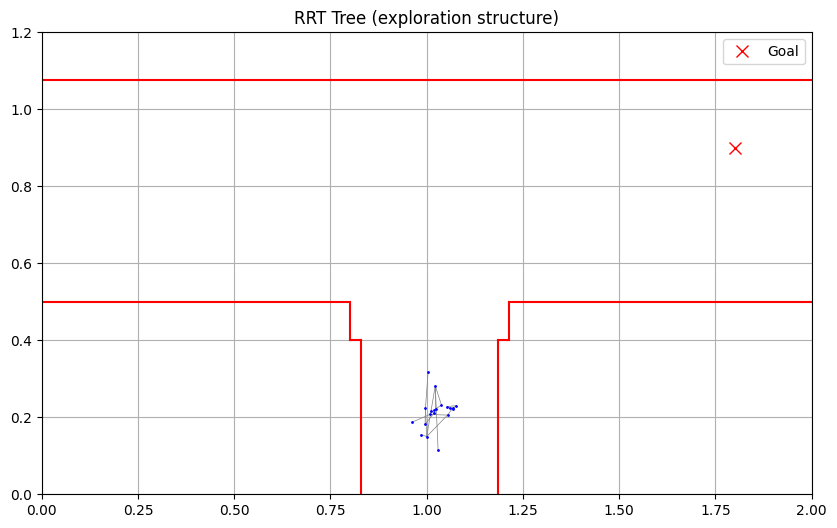

In [337]:
start = EEState(1.0, 0.15, 270)
goal = EEState(1.8, 0.9, 60)

if not goal.is_valid(EE_full, is_within_custom_bounds):
    print("❌ Goal state is invalid!")

goal_node, tree = rrt_plan(
    start, goal,
    EE_full,
    is_within_custom_bounds,
    max_iter=10000,               # 更长迭代
    goal_sample_rate=0.2          # 引导采样
)

if goal_node:
    path = extract_path(goal_node)
    plot_rrt_path(path, EE_full, draw_borders)
else:
    print("❌ Failed to find a path.")
    plot_rrt_tree(tree, EE_full, draw_borders, goal_state=goal)

In [333]:
import numpy as np

class EEState:
    def __init__(self, x, y, theta_deg):
        self.x = x
        self.y = y
        self.theta_deg = theta_deg
        self.center = x + 1j * y

    def transform(self, EE_full):
        """返回当前状态下的 EE 形状（复数数组）"""
        theta_rad = np.deg2rad(self.theta_deg)
        return (EE_full - 0.385) * np.exp(1j * theta_rad) + self.center

    def is_valid(self, EE_full, bounds_func):
        EE_trans = self.transform(EE_full)
        result = np.all(bounds_func(EE_trans))
        if not result:
            print(f"🚫 Invalid at x={self.x:.3f}, y={self.y:.3f}, θ={self.theta_deg:.1f}")
        return result

    def distance_to(self, other_state):
        """状态之间的欧几里得距离 + 角度差作为 cost"""
        dx = self.x - other_state.x
        dy = self.y - other_state.y
        dtheta = (self.theta_deg - other_state.theta_deg + 180) % 360 - 180
        return np.sqrt(dx**2 + dy**2) + abs(dtheta) / 180  # 角度也参与代价

In [334]:
import random
import numpy as np # Import numpy

class RRTNode:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent

def sample_random_state(x_range, y_range, theta_range=(0, 360), goal_state=None, goal_sample_rate=0.2):
    """引导采样：有一定概率直接采样目标点"""
    if goal_state and random.random() < goal_sample_rate:
        return goal_state
    x = random.uniform(*x_range)
    y = random.uniform(*y_range)
    theta = random.uniform(*theta_range)
    return EEState(x, y, theta)

def find_nearest_node(tree, new_state):
    min_dist = float('inf')
    nearest = None
    for node in tree:
        d = node.state.distance_to(new_state)
        if d < min_dist:
            min_dist = d
            nearest = node
    return nearest

def steer_towards(from_state, to_state, step_size=0.02, max_angle_step=15, EE_full=None, bounds_func=None): # Adjusted step_size and max_angle_step
    dx = to_state.x - from_state.x
    dy = to_state.y - from_state.y
    dtheta = (to_state.theta_deg - from_state.theta_deg + 540) % 360 - 180  # 差值角限制在 [-180, 180]

    dist = np.hypot(dx, dy)
    steps = max(int(dist / step_size), int(abs(dtheta) / max_angle_step), 1)

    for i in range(1, steps + 1):
        ratio = i / steps
        x = from_state.x + dx * ratio
        y = from_state.y + dy * ratio
        theta_deg = (from_state.theta_deg + dtheta * ratio) % 360

        intermediate = EEState(x, y, theta_deg)
        if EE_full is not None and bounds_func is not None:
            if not intermediate.is_valid(EE_full, bounds_func):
                print(f"❌ 无效中间点: x={x:.2f}, y={y:.2f}, θ={theta_deg:.1f}") # Keep print for debugging
                return None  # Collision detected, return failure

    # Return the final state if no collision occurred along the path
    final_state = EEState(to_state.x, to_state.y, to_state.theta_deg)
    if EE_full is not None and bounds_func is not None:
        if not final_state.is_valid(EE_full, bounds_func):
            print(f"❌ 最终点非法: {final_state.x:.2f}, {final_state.y:.2f}, {final_state.theta_deg:.1f}") # Keep print for debugging
            return None
    return final_state

In [335]:
import matplotlib.pyplot as plt

def rrt_plan(start_state, goal_state, EE_full, bounds_func, max_iter=1000, goal_sample_rate=0.2):
    tree = [RRTNode(start_state)]
    goal_tolerance = 0.1

    for iter_idx in range(max_iter):
        # === 引导采样 ===
        rand_state = sample_random_state(
            (0.05, 1.95), (0.05, 1.15), goal_state=goal_state, goal_sample_rate=goal_sample_rate
        )

        nearest = find_nearest_node(tree, rand_state)
        # Pass EE_full and bounds_func to steer_towards
        new_state = steer_towards(nearest.state, rand_state, EE_full=EE_full, bounds_func=bounds_func)

        if new_state is None: # steer_towards returns None on collision
             continue

        # This check is redundant now that steer_towards handles validity
        # if not new_state.is_valid(EE_full, bounds_func):
        #     continue

        new_node = RRTNode(new_state, nearest)
        tree.append(new_node)

        # 是否到达目标
        if new_state.distance_to(goal_state) < goal_tolerance:
            # Keep the goal state validity check
            if goal_state.is_valid(EE_full, bounds_func):  # 目标状态也要合法
                goal_node = RRTNode(goal_state, new_node) # Connect the goal to the nearest node found
                tree.append(goal_node)
                return goal_node, tree

    return None, tree

def extract_path(goal_node):
    """从目标节点回溯出路径（防止环、自循环、空节点等异常）"""
    path = []
    node = goal_node
    visited = set()  # 防止循环引用死循环

    while node is not None:
        if id(node) in visited:
            print("⚠️ Detected circular reference in path! Abort.")
            break
        visited.add(id(node))
        path.append(node.state)
        node = node.parent

    if not path:
        print("⚠️ Empty path extracted.")
        return []

    return path[::-1]  # 起点在前，终点在后

def plot_rrt_path(path, EE_full, draw_borders):
    # ✅ 在开始时逐步检查路径点是否合法
    for i, state in enumerate(path):
        shape = state.transform(EE_full)
        if not is_within_custom_bounds(shape):
            print(f"❗ 第 {i} 步越界：({state.x:.2f}, {state.y:.2f}, θ={state.theta_deg:.1f})")

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1.2)
    ax.set_aspect('equal')
    draw_borders(ax)

    for state in path:
        EE_trans = state.transform(EE_full)
        ax.fill(EE_trans.real, EE_trans.imag, alpha=0.3, color='gray')

    ax.plot([s.x for s in path], [s.y for s in path], 'b.-', label='Planned Path')
    ax.set_title("RRT-Connect Path")
    plt.legend()
    plt.grid(True)
    plt.show()

In [336]:
start = EEState(1.0, 0.15, 270)
goal = EEState(1.8, 0.9, 60)

goal_node, tree = rrt_plan(start, goal, EE_full, is_within_custom_bounds, max_iter=2000)

if goal_node:
    path = extract_path(goal_node)
    plot_rrt_path(path, EE_full, draw_borders)
else:
    print("❌ Failed to find a path.")


🚫 Invalid at x=0.979, y=0.154, θ=282.9
❌ 无效中间点: x=0.98, y=0.15, θ=282.9
🚫 Invalid at x=0.968, y=0.246, θ=264.5
❌ 无效中间点: x=0.97, y=0.25, θ=264.5
🚫 Invalid at x=1.076, y=0.216, θ=280.1
❌ 无效中间点: x=1.08, y=0.22, θ=280.1
🚫 Invalid at x=1.074, y=0.219, θ=283.9
❌ 无效中间点: x=1.07, y=0.22, θ=283.9
🚫 Invalid at x=1.113, y=0.193, θ=259.5
❌ 无效中间点: x=1.11, y=0.19, θ=259.5
🚫 Invalid at x=0.996, y=0.251, θ=283.1
❌ 无效中间点: x=1.00, y=0.25, θ=283.1
🚫 Invalid at x=0.922, y=0.213, θ=291.4
❌ 无效中间点: x=0.92, y=0.21, θ=291.4
🚫 Invalid at x=1.086, y=0.235, θ=253.8
❌ 无效中间点: x=1.09, y=0.24, θ=253.8
🚫 Invalid at x=0.980, y=0.250, θ=259.7
❌ 无效中间点: x=0.98, y=0.25, θ=259.7
🚫 Invalid at x=0.998, y=0.252, θ=268.5
❌ 无效中间点: x=1.00, y=0.25, θ=268.5
🚫 Invalid at x=0.931, y=0.249, θ=268.3
❌ 无效中间点: x=0.93, y=0.25, θ=268.3
🚫 Invalid at x=1.074, y=0.219, θ=283.9
❌ 无效中间点: x=1.07, y=0.22, θ=283.9
🚫 Invalid at x=1.051, y=0.239, θ=245.3
❌ 无效中间点: x=1.05, y=0.24, θ=245.3
🚫 Invalid at x=1.023, y=0.248, θ=273.7
❌ 无效中间点: x=1.02, y=0.25, 

In [338]:
# == 设置关键位置 ==
start = EEState(1.0, 0.15, 270)
mid   = EEState(1.25, 0.9, 60)
goal  = EEState(1.8, 0.9, 60)

# == 运行两段路径 ==
# Check validity of start, mid, and goal states
if not start.is_valid(EE_full, is_within_custom_bounds):
    print("❌ Start state is invalid!")
elif not mid.is_valid(EE_full, is_within_custom_bounds):
    print("❌ Intermediate state is invalid!")
elif not goal.is_valid(EE_full, is_within_custom_bounds):
    print("❌ Goal state is invalid!")
else:
    print("🚩 正在规划起点 → 中继点...")
    path1, tree1 = rrt_connect(start, mid, EE_full, is_within_custom_bounds, max_iter=5000) # Removed goal_sample_rate

    print("🚩 正在规划中继点 → 终点...")
    path2, tree2 = rrt_connect(mid, goal, EE_full, is_within_custom_bounds, max_iter=5000) # Removed goal_sample_rate

    # == 合并并可视化 ==
    if path1 and path2:
        full_path = path1[:-1] + path2  # 避免中间点重复
        plot_rrt_path(full_path, EE_full, draw_borders)
        print(f"✅ 路径规划成功，总节点数：{len(full_path)}")
    else:
        print("❌ 任一子路径失败，请尝试调整中继点或增加迭代次数")

流式输出内容被截断，只能显示最后 5000 行内容。
❌ 无效中间点: x=0.85, y=0.33, θ=0.7
🚫 Invalid at x=0.842, y=0.629, θ=342.7
❌ 无效中间点: x=0.84, y=0.63, θ=342.7
🚫 Invalid at x=1.073, y=0.258, θ=210.1
❌ 无效中间点: x=1.07, y=0.26, θ=210.1
🚫 Invalid at x=0.686, y=0.988, θ=170.2
❌ 无效中间点: x=0.69, y=0.99, θ=170.2
🚫 Invalid at x=0.981, y=0.269, θ=2.4
❌ 无效中间点: x=0.98, y=0.27, θ=2.4
🚫 Invalid at x=1.564, y=0.657, θ=285.1
❌ 无效中间点: x=1.56, y=0.66, θ=285.1
🚫 Invalid at x=0.940, y=0.220, θ=252.4
❌ 无效中间点: x=0.94, y=0.22, θ=252.4
🚫 Invalid at x=0.140, y=0.680, θ=154.7
❌ 无效中间点: x=0.14, y=0.68, θ=154.7
🚫 Invalid at x=1.070, y=0.269, θ=236.3
❌ 无效中间点: x=1.07, y=0.27, θ=236.3
🚫 Invalid at x=0.987, y=0.269, θ=216.5
❌ 无效中间点: x=0.99, y=0.27, θ=216.5
🚫 Invalid at x=0.942, y=0.198, θ=344.4
❌ 无效中间点: x=0.94, y=0.20, θ=344.4
🚫 Invalid at x=1.091, y=0.252, θ=213.7
❌ 无效中间点: x=1.09, y=0.25, θ=213.7
🚫 Invalid at x=0.970, y=0.166, θ=208.2
❌ 无效中间点: x=0.97, y=0.17, θ=208.2
🚫 Invalid at x=0.641, y=0.131, θ=330.4
❌ 无效中间点: x=0.64, y=0.13, θ=330.4
🚫 Invalid 

In [339]:
def plot_rrt_tree(tree, EE_full, draw_borders, goal_state=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1.2)
    ax.set_aspect('equal')
    draw_borders(ax)

    for node in tree:
        if node.parent:
            ax.plot(
                [node.state.x, node.parent.state.x],
                [node.state.y, node.parent.state.y],
                'gray', linewidth=0.5
            )
    for node in tree:
        ax.plot(node.state.x, node.state.y, 'bo', markersize=1)

    if goal_state:
        ax.plot(goal_state.x, goal_state.y, 'rx', markersize=8, label="Goal")

    ax.set_title("RRT Tree (exploration structure)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [340]:
def is_within_custom_bounds(ee_shape):
    """
    Checks if the End Effector shape (complex numbers) is within the defined custom bounds.
    The bounds are defined by the border segments in draw_borders.
    """
    # Define the boundaries
    # These correspond to the segments defined in draw_borders
    x_bounds = [0, 2, 0, 0.8, 0.8, 0.83, 0.83, 1.185, 1.185, 1.215, 1.215, 2, 2]
    y_bounds = [0, 0, 0.5, 0.5, 0.4, 0.4, 0, 0, 0.4, 0.4, 0.5, 0.5, 1.075]

    # Check if all points of the EE are within the overall rectangular boundary [0, 2] x [0, 1.075]
    if not (np.all(ee_shape.real >= 0) and np.all(ee_shape.real <= 2) and
            np.all(ee_shape.imag >= 0) and np.all(ee_shape.imag <= 1.075)):
        return False

    # Check against the inner boundaries (the cutout area)
    # A point is outside the cutout if it's within the rectangle [0.8, 1.215] x [0, 0.5]
    # but outside the smaller rectangle [0.83, 1.185] x [0, 0.4]
    cutout_area1 = (ee_shape.real >= 0.8) & (ee_shape.real <= 1.215) & (ee_shape.imag >= 0) & (ee_shape.imag <= 0.5)
    cutout_area2 = (ee_shape.real >= 0.83) & (ee_shape.real <= 1.185) & (ee_shape.imag >= 0) & (ee_shape.imag <= 0.4)

    # If any point is in cutout_area1 but not in cutout_area2, it's in the invalid region
    if np.any(cutout_area1 & ~cutout_area2):
        return False

    return True

In [341]:
def plot_rrt_tree(tree, EE_full, draw_borders, goal_state=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1.2)
    ax.set_aspect('equal')
    draw_borders(ax)

    for node in tree:
        if node.parent:
            ax.plot(
                [node.state.x, node.parent.state.x],
                [node.state.y, node.parent.state.y],
                'gray', linewidth=0.5
            )
    for node in tree:
        ax.plot(node.state.x, node.state.y, 'bo', markersize=1)

    if goal_state:
        ax.plot(goal_state.x, goal_state.y, 'rx', markersize=8, label="Goal")

    ax.set_title("RRT Tree (exploration structure)")
    ax.legend()
    plt.grid(True)
    plt.show()

In [342]:
import numpy as np
import matplotlib.pyplot as plt

# == 双向 RRT 用到的节点类 ==
class RRTNode:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent

def extract_path(goal_node):
    """从目标节点回溯出路径"""
    path = []
    node = goal_node
    while node:
        path.append(node.state)
        node = node.parent
    return path[::-1]

def connect_trees(node1, node2):
    """连接两个树"""
    # This function is not strictly needed for RRT-Connect path extraction
    # but can be useful for visualizing the connection node.
    return RRTNode(node2.state, node1)

def rrt_connect(start_state, goal_state, EE_full, bounds_func, max_iter=1000, goal_tolerance=0.1, max_angle_step=60):
    tree_start = [RRTNode(start_state)]
    tree_goal = [RRTNode(goal_state)]

    for i in range(max_iter):
        # Sample random state
        rand_x = np.random.uniform(0.05, 1.95)
        rand_y = np.random.uniform(0.05, 1.15)
        rand_theta = np.random.uniform(0, 360)
        rand_state = EEState(rand_x, rand_y, rand_theta)

        # Alternate growing trees
        if i % 2 == 0:
            tree_a, tree_b = tree_start, tree_goal
            start_tree_growing = True
        else:
            tree_a, tree_b = tree_goal, tree_start
            start_tree_growing = False

        # Grow tree_a towards random state
        nearest_a = find_nearest_node(tree_a, rand_state)
        # Pass EE_full and bounds_func to steer_towards
        new_state_a = steer_towards(nearest_a.state, rand_state, step_size=0.05, max_angle_step=max_angle_step, EE_full=EE_full, bounds_func=bounds_func)
        if new_state_a is None: # Check if steer_towards returned None due to collision
             continue

        # This check is redundant now that steer_towards handles validity
        # if not new_state_a.is_valid(EE_full, bounds_func):
        #     continue
        new_node_a = RRTNode(new_state_a, nearest_a)
        tree_a.append(new_node_a)

        # Try to connect tree_b to new_node_a
        nearest_b = find_nearest_node(tree_b, new_state_a)
        # Pass EE_full and bounds_func to steer_towards
        new_state_b = steer_towards(nearest_b.state, new_node_a.state, step_size=0.05, max_angle_step=max_angle_step, EE_full=EE_full, bounds_func=bounds_func)
        if new_state_b is None: # Check if steer_towards returned None due to collision
             continue

        # Keep the validity check for the connection point
        if not new_state_b.is_valid(EE_full, bounds_func):
             continue
        new_node_b = RRTNode(new_state_b, nearest_b)
        tree_b.append(new_node_b)


        # ✅ 检查两节点是否靠近，并验证连接状态合法
        if new_state_a.distance_to(new_state_b) < goal_tolerance:
            # Ensure the connection point in both trees is valid (redundant check now)
            # if new_state_b.is_valid(EE_full, bounds_func): # This check is now done earlier
            # Combine paths
            if start_tree_growing:
                # tree_start grew towards tree_goal
                path_start = extract_path(new_node_a)
                path_goal = extract_path(new_node_b)
                # The path from the start tree goes to new_node_a, and the path from the goal tree goes to new_node_b.
                # We need to connect new_node_a's path to new_node_b's path.
                combined_path = path_start + path_goal[::-1] # Reverse goal path and append
                print(f"✅ Found path on iteration {i}, total nodes: {len(combined_path)}")
                return combined_path, tree_start + tree_goal
            else:
                # tree_goal grew towards tree_start
                path_start = extract_path(new_node_b) # new_node_b is in tree_start
                path_goal = extract_path(new_node_a) # new_node_a is in tree_goal
                 # The path from the start tree goes to new_node_b, and the path from the goal tree goes to new_node_a.
                # We need to connect new_node_b's path to new_node_a's path.
                combined_path = path_start + path_goal[::-1] # Reverse goal path and append
                print(f"✅ Found path on iteration {i}, total nodes: {len(combined_path)}")
                return combined_path, tree_start + tree_goal


    return None, tree_start + tree_goal  # failed

from IPython.display import display
import matplotlib.patches as patches

def plot_rrt_path(path, EE_full, draw_borders):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1.2)
    ax.set_aspect('equal')
    draw_borders(ax)

    for state in path:
        # Assuming EEState has a transform method that takes EE_full
        EE_trans = state.transform(EE_full)
        ax.fill(EE_trans.real, EE_trans.imag, alpha=0.3, color='gray')

    ax.plot([s.x for s in path], [s.y for s in path], 'b.-', label='Planned Path')
    ax.set_title("RRT-Connect Path")
    plt.legend()
    plt.grid(True)
    plt.show()